In [10]:
library(here)
source(here("code/setup.R"))
library(latex2exp)

# RKI data - reporting triangle

As this model uses the reporting delay for incidences, we use the reporting triangle for the number of cases, i.e. on any day $t$ the number of cases $$I_{s,t}$$ that are reported associated with date $s < t$. 

We begin our analysis on April 1st 2020, when data have become stable enough to warrant an analysis.

In [115]:
full_rep_tri <- read_csv(here("data/raw/rki_cases_deaths_delays.csv")) %>%
    select(t = rki_date, s = county_date, I = cases) %>%
    filter(s >= ymd("2020-04-01"))

In [163]:
full_rep_tri %>% pull(t) %>% max

[1] "2023-10-13"

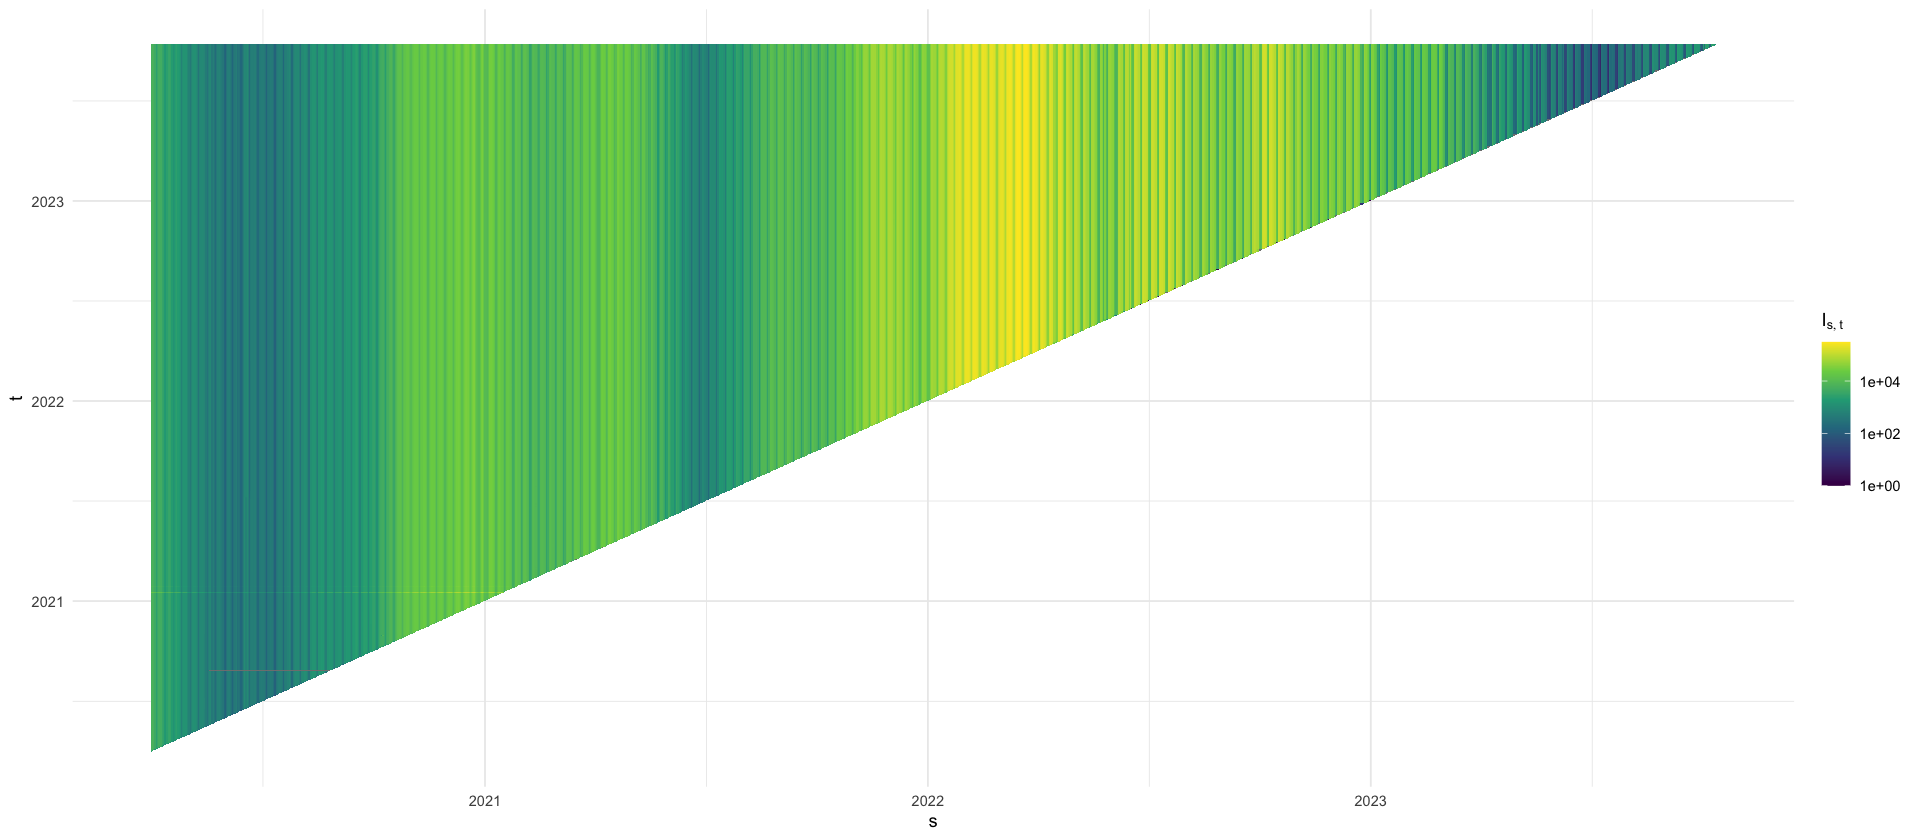

In [117]:
full_rep_tri %>%
    mutate(I = ifelse(I < 1, NA, I)) %>%
    ggplot(aes(x = s, y = t, fill = I)) +
    geom_tile() +
    scale_fill_viridis_c(trans="log10") +
    labs(x="s", y="t", fill=TeX("$I_{s,t}$"))

How often is $I_{s,t} > I_{s,T}$?

q90,q95,q99,q999
<dbl>,<dbl>,<dbl>,<dbl>
0.4065041,0.6497726,1.840491,16.1435


t,s,I,rel_diff,rel_diff_pct
<date>,<date>,<dbl>,<dbl>,<dbl>
2021-01-17,2020-12-24,58712,1.779924,177.9924
2021-01-17,2021-01-03,24542,1.781594,178.1594
2021-01-17,2020-11-30,36988,1.781889,178.1889
2021-01-17,2020-12-31,54618,1.792331,179.2331
2021-01-17,2020-12-21,56628,1.792996,179.2996
2021-01-17,2021-01-02,27996,1.799040,179.9040
2021-01-17,2021-01-10,23721,1.800921,180.0921
2021-01-17,2021-01-04,40161,1.805323,180.5323
2021-01-17,2021-01-05,77088,1.808306,180.8306


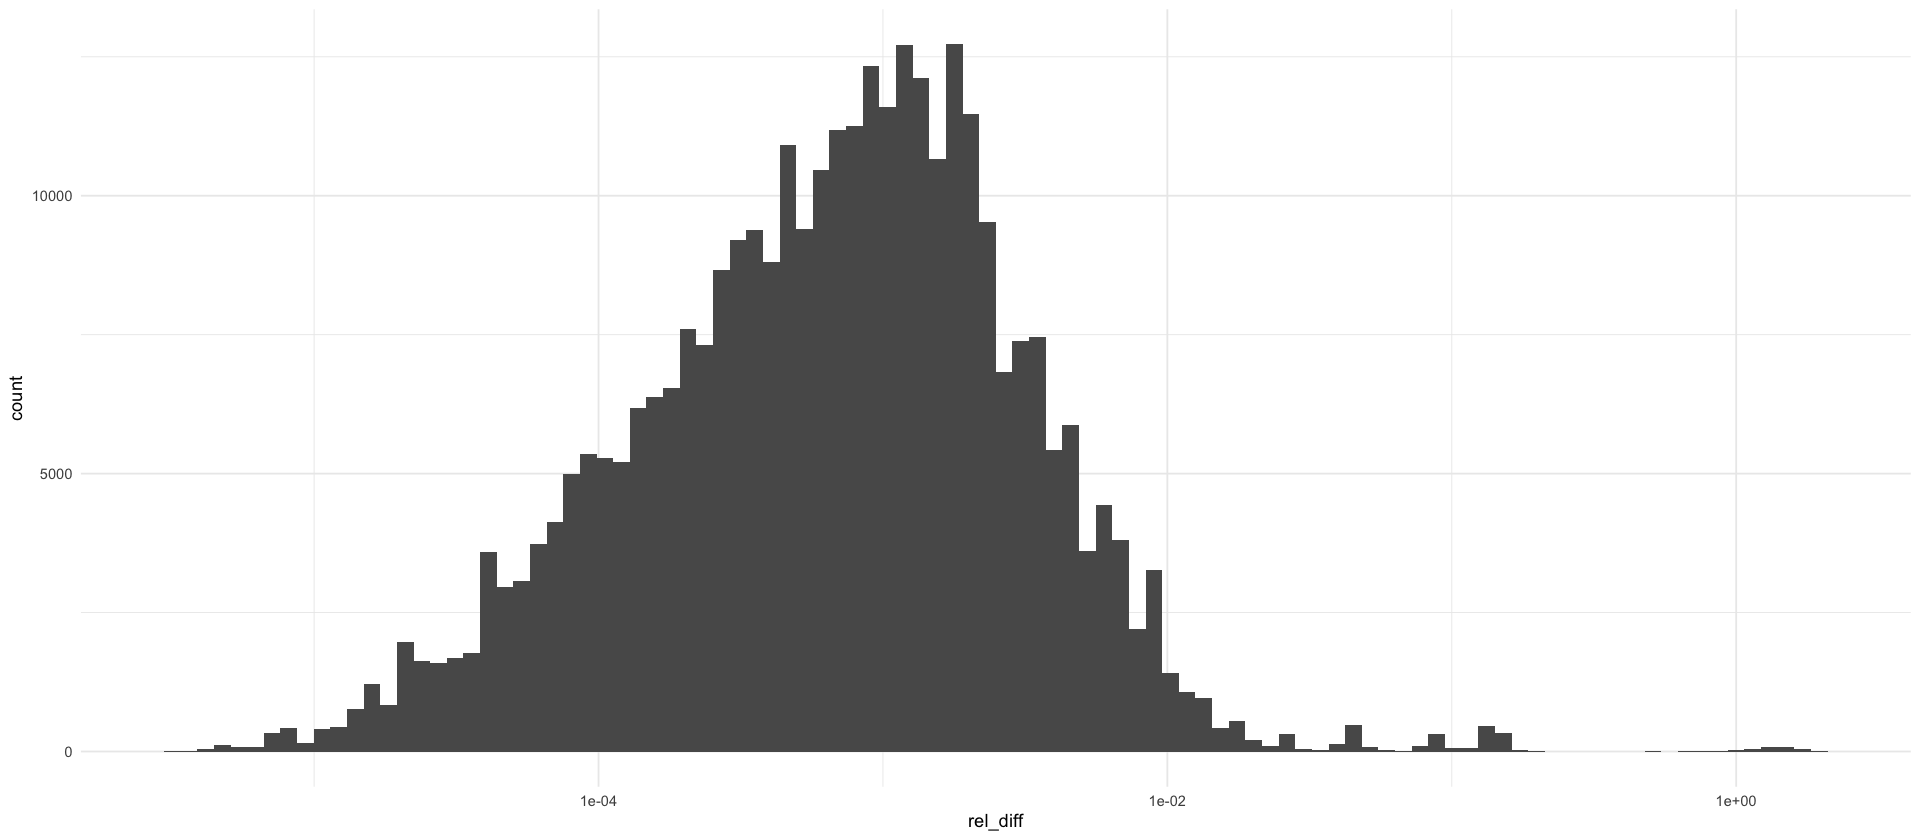

In [184]:
rel_diffs <- full_rep_tri %>%
    group_by(s) %>%
    arrange(t) %>%
    mutate(rel_diff = (I - tail(I, 1)) / tail(I, 1)) %>%
    ungroup() %>%
    filter(rel_diff > 0) %>%
    mutate(rel_diff_pct = rel_diff * 100) 

rel_diffs %>%
    ggplot(aes(x = rel_diff)) +
    geom_histogram(bins = 100) +
    scale_x_log10()

rel_diffs %>%
    summarize(
        q90 = quantile(rel_diff_pct, .9),
        q95 = quantile(rel_diff_pct, .95),
        q99 = quantile(rel_diff_pct, .99),
        q999 = quantile(rel_diff_pct, .999)
    )

rel_diffs %>%
    arrange(rel_diff_pct) %>%
    tail(20)

pdf 
  2

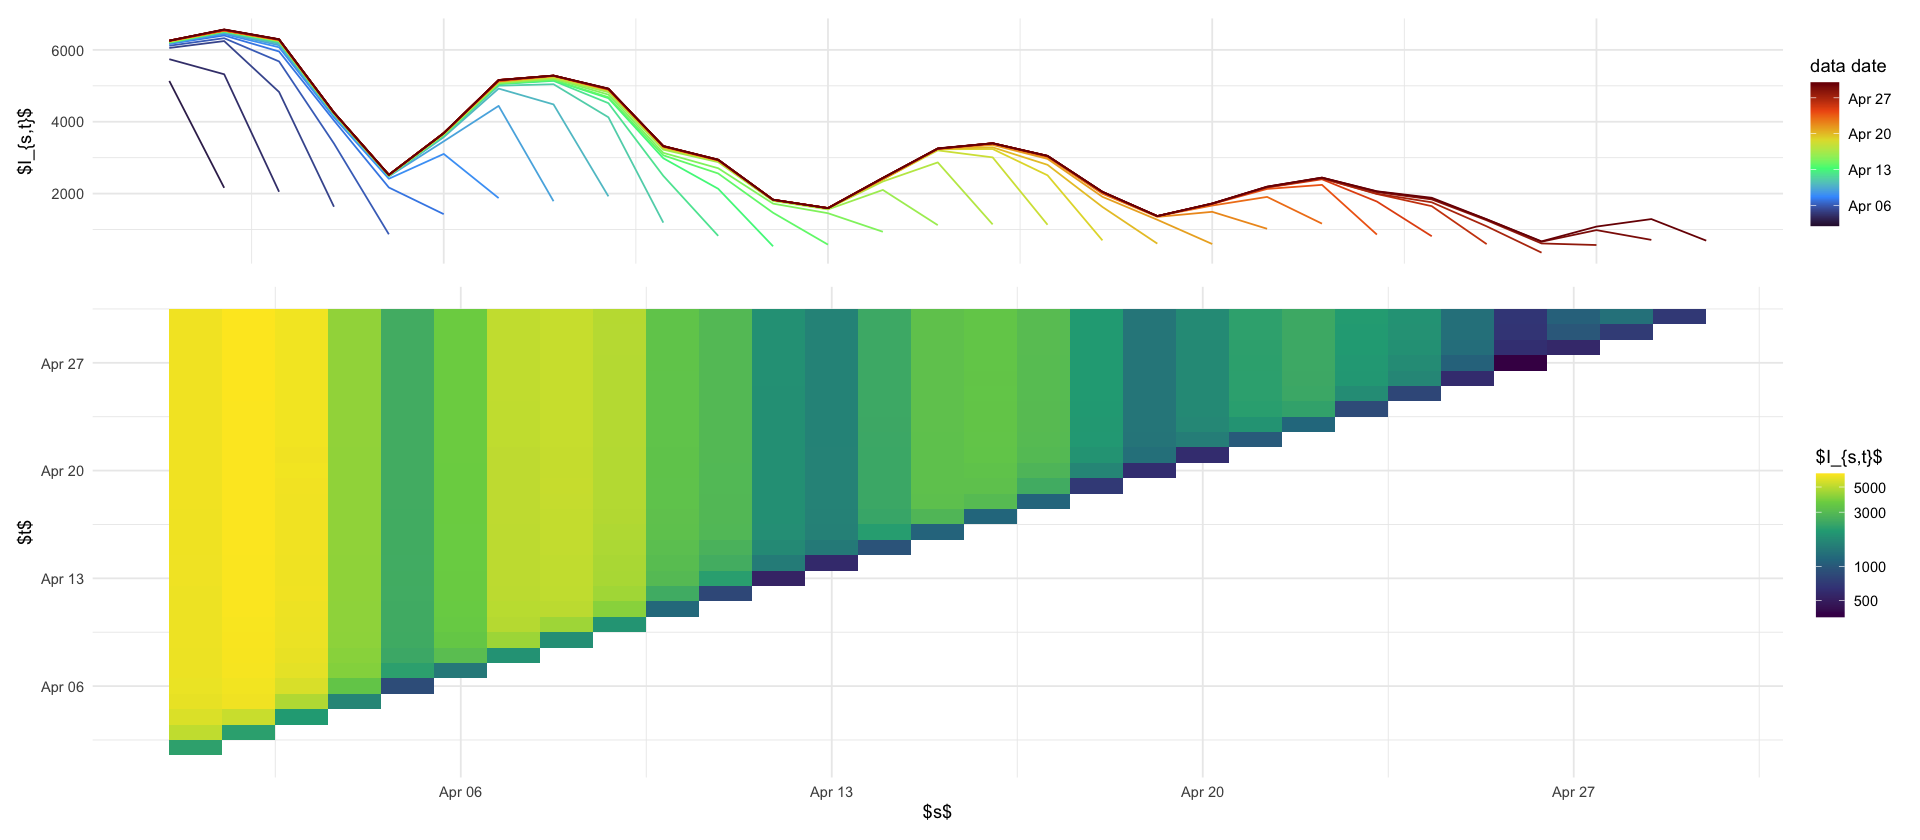

In [222]:
data_april <- full_rep_tri %>%
    filter(s < ymd("2020-05-01")) %>%
    filter(t < ymd("2020-05-01")) 
p_triangle <- data_april %>%
    ggplot(aes(x = s, y = t, fill = I)) +
    geom_tile() +
    scale_fill_viridis_c(trans = "log10") +
    labs(x = "$s$", y = "$t$", fill = "$I_{s,t}$")

p_marginal <- data_april %>%
    ggplot(aes(x = s, y = I, color=t, group=factor(t))) +
    geom_line() +
    theme(axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank()) +
    labs(x = "", y = "$I_{s,t}$", color="data date") +
    scale_color_viridis_c(option="H", trans="date")

(p_marginal / p_triangle) + plot_layout(heights = c(1, 2))
ggsave_tikz(here("tikz/reporting_delays_cases.tex"))

We are only interested in the number of _newly_ reported cases on each day. Let 
$$
    I_{s,t} = \sum_{\tau = 0}^{t - s} i_{s, \tau}
$$
be the distribution of reported on date $t$ for date $s$. We will assume that $i_{s,\tau} \geq 0$ always holds. To ensure this, let $T$ be the last date observed and set 
$$
    \tilde I_{s,t} = \min \{\max \{I_{s,s}, \dots, I_{s,t}\}, I_{s,T}\}.
$$
$\tilde I_{s,t}$ is a running maximum that is cut-off at the final value $I_{s,T}$ (to deal with big rearrangements of cases, due to missingness or faulty data).

Warning message in scale_fill_viridis_c(trans = "log10", na.value = rgb(0, 0, 0, :
“log-10 transformation introduced infinite values.”


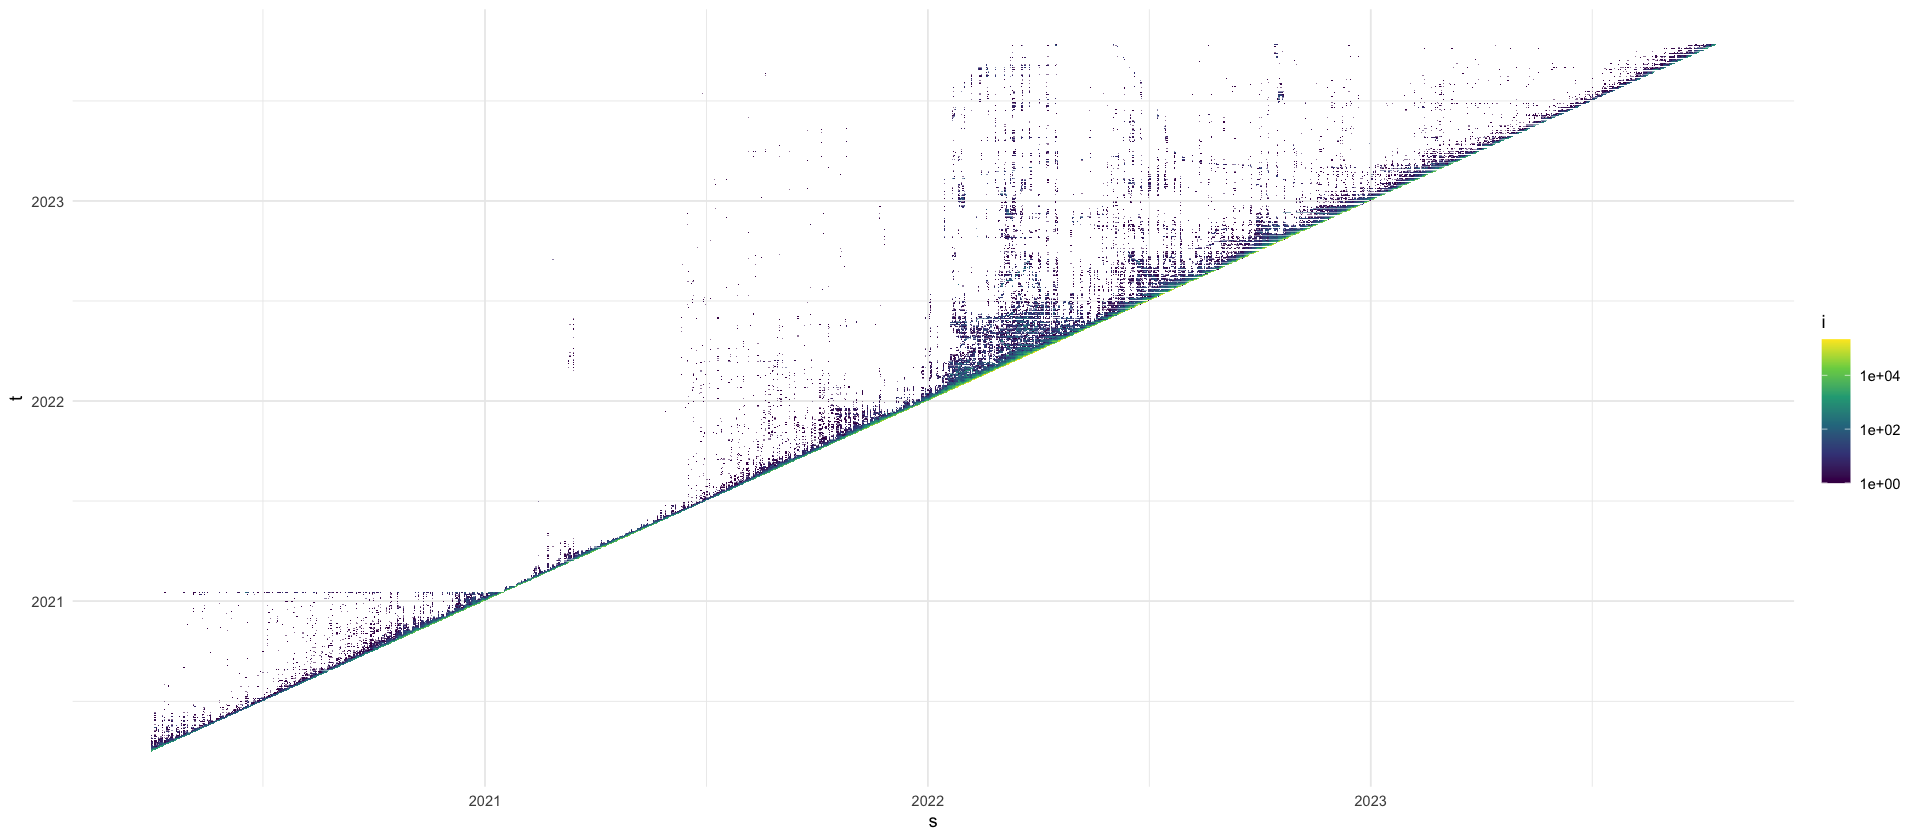

In [118]:
rep_tri_cummax <- full_rep_tri %>%
    arrange(t) %>%
    group_by(s)  %>%
    mutate(
        I_tilde = pmin(cummax(I), tail(I, 1)),
    ) %>%
    ungroup()

increments <- rep_tri_cummax %>%
    group_by(s) %>%
    mutate(
        i = I_tilde - lag(I_tilde, default = 0),
    ) %>%
    ungroup()

stopifnot(all(increments$i >= 0))

increments %>%
    ggplot(aes(x = s, y = t, fill = i)) +
    geom_tile() +
    scale_fill_viridis_c(trans="log10", na.value = rgb(0,0,0,0))

We see that most delays are short. Let us investigate the proportion of reported cases with delay $\tau = t - s$:

$$
    p_{\tau} = \frac{\sum_{t - s = \tau} i_{s, t}}{\sum_{t,s} i_{s,t}}
$$

and we will look at the survival function 
$$
    \hat S(\tau) =  1- \sum_{\tau' \leq \tau} p_{\tau'}
$$
which measures the fraction of cases reported after $\tau$ days of delay.

pdf 
  2

tau,total,p,S
<dbl>,<dbl>,<dbl>,<dbl>
8,84632,2.201627e-03,0.009806282
9,44738,1.163820e-03,0.008642463
10,27331,7.109919e-04,0.007931471
11,21702,5.645584e-04,0.007366912
12,18534,4.821457e-04,0.006884767
13,14666,3.815231e-04,0.006503244
14,12321,3.205200e-04,0.006182724
15,11859,3.085014e-04,0.005874222
16,13002,3.382356e-04,0.005535987


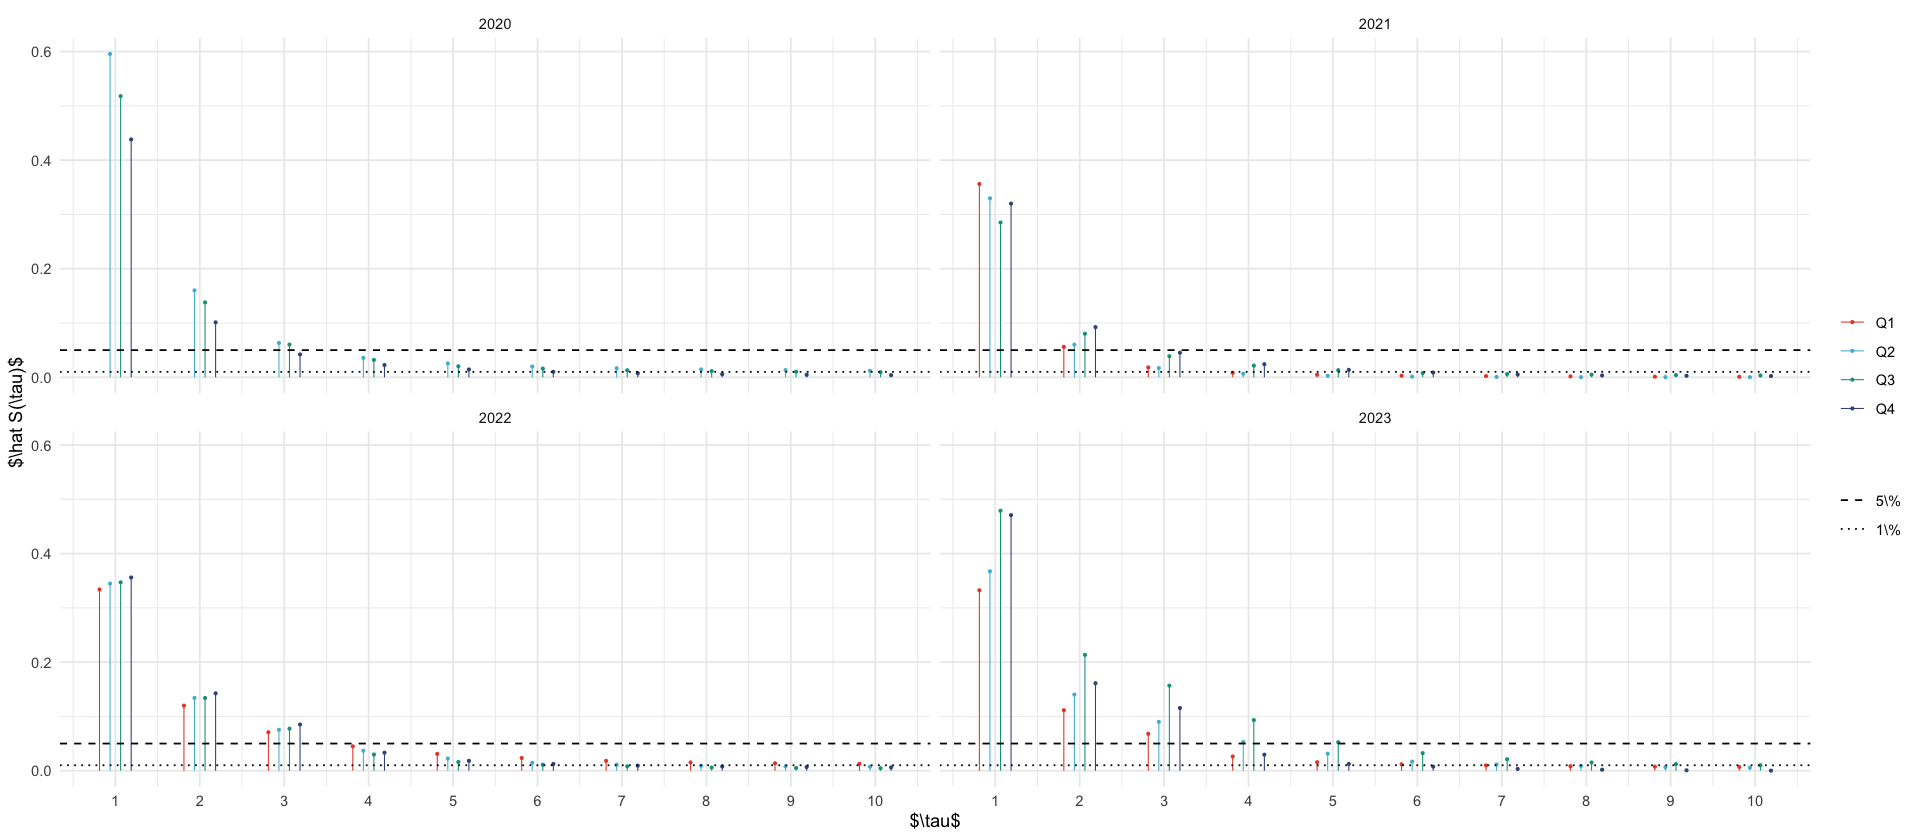

In [207]:
total_S <- increments %>%
    mutate(tau = as.numeric(t - s)) %>%
    group_by(tau) %>%
    summarize(total = sum(i)) %>%
    ungroup() %>%
    mutate(p = total / sum(total)) %>%
    mutate(S = 1 - cumsum(p))
    
quarter_S <- increments %>%
    mutate(tau = as.numeric(t - s)) %>%
    group_by(quarter = floor_date(s, "quarter"), tau) %>%
    summarize(total = sum(i)) %>%
    mutate(p = total / sum(total)) %>%
    mutate(S = 1 - cumsum(p)) %>%
    ungroup()

quarter_S %>%
    filter(tau <= 10) %>%
    #mutate(label = ifelse(tau %in% c(4,8), paste(round(S * 100, 1), "\\%") , NA)) %>%
    mutate(group = as.numeric(quarter(quarter))) %>%
    mutate(x = tau + (group - 2.5) / 8) %>%
    ggplot(aes(x = x, y = S, color = paste0("Q", as.character(group)))) +
    geom_point(size=.5) +
    geom_segment(aes(x = x, xend=  x, y = S, yend =0), linewidth=.3) +
    geom_hline(aes(yintercept = y, linetype = name), data = tibble(y = c(.05, .01), name=factor(2:3, labels=c("5\\%", "1\\%")))) +
    #geom_text(aes(label=label, y = S + .05)) +
    scale_linetype_manual(values = c("dashed", "dotted")) +
    scale_x_continuous(breaks = 0:10) +
    labs(x = "$\\tau$", y = "$\\hat S(\\tau)$", color="", linetype="") +
    facet_wrap(~year(quarter))

ggsave_tikz(here("tikz/survival_function_rep_tri_incidences.tex"))

total_S %>%
    filter(S <= .01)

As $S(4) \leq 5\%$ for most quarters, most of the cases have been reported until day $4$, and we will depen on only these first four days. Additionally, only 31st of March 2020 has $i_{t,0} > 0$, so reporting on the same day is excluded usually. We start our analysis with cases starting in April 1st 2020.

In [129]:
increments %>%
    mutate(tau = as.numeric(t - s)) %>%
    filter(tau == 0, i > 0)
 
increments %>%
    mutate(tau = as.numeric(t - s)) %>%
    filter(s >= ymd("2020-04-01")) %>%
    select(s, tau, i) %>%
    filter(tau <= 4) %>%
    pivot_wider(names_from = tau, values_from = i) %>%
    rename(date = s) %>%
    write_csv(here("data/RKI_4day_rt.csv"))

t,s,I,I_tilde,i,tau
<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
